## Giới thiệu Modeling

Mục tiêu của giai đoạn Modeling là xây dựng và đánh giá các mô hình dự đoán giá xe dựa trên tập dữ liệu đã được tiền xử lý và chọn lọc đặc trưng. Giai đoạn này tập trung vào việc kiểm tra nhiều thuật toán học máy, tối ưu hóa siêu tham số, và đánh giá hiệu quả mô hình thông qua các thước đo phù hợp.

Quy trình Modeling được tổ chức thành các phase rõ ràng như sau:

```
Phase I — Chuẩn bị dữ liệu cho Modeling
├── 1.1 Load dataset đã tiền xử lý
├── 1.2 Xác định tập đặc trưng (X) và biến mục tiêu (y)
├── 1.3 Chia dữ liệu thành tập Train và Test
├── 1.4 Kiểm tra tính tương thích của dữ liệu với mô hình
└── 1.5 Chuẩn bị chiến lược Feature Scaling


Phase II — Benchmark Models
├── 2.1 Linear Regression (Baseline)
├── 2.2 Ridge Regression
├── 2.3 Random Forest
├── 2.4 XGBoost / LightGBM
└── 2.5 CatBoost


Phase III — Hyperparameter Tuning & Cross-validation
├── 3.1 Xác định mô hình tiềm năng
├── 3.2 Thiết lập không gian siêu tham số
├── 3.3 GridSearchCV / RandomizedSearchCV
├── 3.4 K-fold Cross-validation
└── 3.5 Lựa chọn bộ siêu tham số tối ưu


Phase IV — Đánh giá mô hình (Evaluation)
├── 4.1 Đánh giá trên tập Test (RMSE, MAE, R²)
├── 4.2 So sánh Actual vs Predicted
├── 4.3 Phân tích Residual
├── 4.4 Phân phối lỗi dự đoán (Error Distribution)
└── 4.5 Tổng hợp kết quả đánh giá


Phase V — Lựa chọn mô hình & Giải thích
├── 5.1 So sánh hiệu suất giữa các mô hình
├── 5.2 Lựa chọn mô hình tối ưu
├── 5.3 Phân tích Feature Importance / SHAP
├── 5.4 Đánh giá ưu và nhược điểm của mô hình
└── 5.5 Kết luận và định hướng cải tiến
```

### Import thư viện cần thiết

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import shap

## Phase I — Chuẩn bị dữ liệu cho Modeling

Giai đoạn này nhằm chuẩn bị toàn bộ dữ liệu đầu vào để đảm bảo mô hình có thể huấn luyện một cách ổn định, chính xác và có khả năng tổng quát hóa cao. Các bước thực hiện gồm:

### 1. Nạp và kiểm tra dataset cuối cùng
- Tải dataset sau khi hoàn tất toàn bộ preprocessing và encoding.
- Kiểm tra kích thước, kiểu dữ liệu, missing values và sự nhất quán của dữ liệu.

### 2. Xác định tập biến đặc trưng (X) và biến mục tiêu (y)
- Target: `price_million`
- X: toàn bộ các đặc trưng numerical + encoded categorical
- Kiểm tra số lượng đặc trưng và đảm bảo tất cả đã ở dạng number.

### 3. Train–test split
- Chia dữ liệu theo tỉ lệ 80% training – 20% testing.
- Kiểm tra phân phối target giữa train/test để đảm bảo không lệch phân phối.

### 4. Kiểm tra khả năng tương thích của dữ liệu với mô hình
- Đảm bảo không còn datatype dạng object.
- Không có NaN hoặc giá trị vô hạn.
- Kiểm tra thống kê mô tả để phát hiện vấn đề tiềm ẩn.

### 5. Chuẩn bị strategy cho Feature Scaling (nếu mô hình yêu cầu)
- Linear Regression, Lasso, Ridge, SVR, KNN cần scaling.
- Tree-based models (RF, XGB, LGBM, CatBoost) không cần scaling.
- Scaling sẽ được thực hiện trong Pipeline ở phase sau.

Sau Phase I, dữ liệu đã sẵn sàng hoàn toàn cho quá trình huấn luyện nhiều mô hình trong Phase II.

### 1. Load datasets

In [2]:
df = pd.read_csv('../datasets/preprocessed_car_features.csv')

### 2. Xác định tập đặc trưng (X) và biến mục tiêu (y)

Biến mục tiêu cho bài toán dự đoán là `price_million`.
Tập đặc trưng X bao gồm toàn bộ các biến còn lại

In [3]:
target_col = "price_million"

X = df.drop(columns=[target_col])
y = df[target_col]

print("Số lượng features:", X.shape[1])
X.columns.tolist()

Số lượng features: 69


['km',
 'seats',
 'engine',
 'engine_missing',
 'age',
 'km_per_year',
 'is_luxury',
 'usage',
 'transmission_binary',
 'fuel_diesel',
 'fuel_electric',
 'fuel_gasoline',
 'fuel_hybrid',
 'inland_binary',
 'new_binary',
 'body_type_convertible',
 'body_type_coupe',
 'body_type_hatchback',
 'body_type_minivan',
 'body_type_other',
 'body_type_pickup',
 'body_type_sedan',
 'body_type_suv',
 'body_type_truck',
 'body_type_wagon',
 'city_ba_ria',
 'city_bac_ninh',
 'city_binh_duong',
 'city_can_tho',
 'city_da_nang',
 'city_dak_lak',
 'city_dong_nai',
 'city_gia_lai',
 'city_ha_noi',
 'city_hai_phong',
 'city_ho_chi_minh',
 'city_lam_dong',
 'city_nghe_an',
 'city_other',
 'city_phu_tho',
 'city_quang_ninh',
 'city_thanh_hoa',
 'city_unknow',
 'city_vinh_phuc',
 'brand_audi',
 'brand_bmw',
 'brand_chevrolet',
 'brand_daewoo',
 'brand_ford',
 'brand_honda',
 'brand_hyundai',
 'brand_isuzu',
 'brand_kia',
 'brand_landrover',
 'brand_lexus',
 'brand_mazda',
 'brand_mercedes_benz',
 'brand_mg'

### 3. Chia dữ liệu thành tập Train và Test

Dữ liệu được chia theo tỷ lệ 80% huấn luyện và 20% kiểm tra.
Tập kiểm tra được dùng để đánh giá khả năng tổng quát hóa của mô hình trên dữ liệu mới.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (10869, 69)
Test shape: (2718, 69)


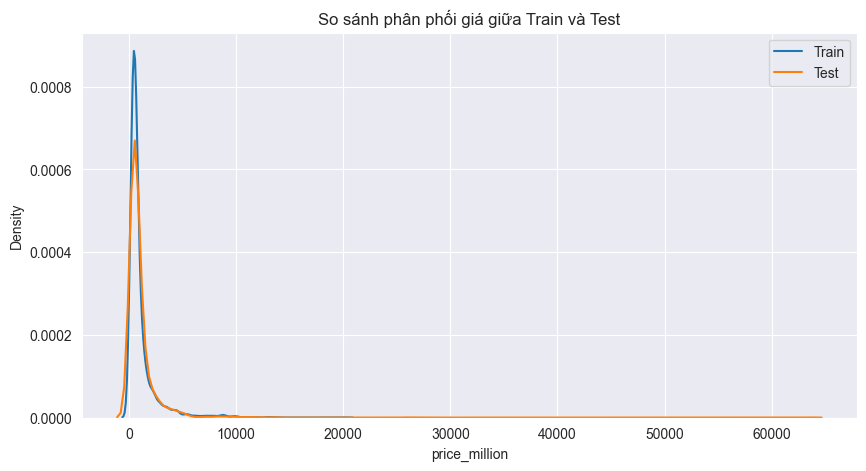

In [5]:
plt.figure(figsize=(10,5))
sns.kdeplot(y_train, label="Train")
sns.kdeplot(y_test, label="Test")
plt.legend()
plt.title("So sánh phân phối giá giữa Train và Test")
plt.show()

### 4. Kiểm tra tính tương thích của dữ liệu với mô hình

Mục tiêu:
- Đảm bảo không còn giá trị NaN sau train-test split.
- Đảm bảo toàn bộ feature ở dạng số (numeric).
- Kiểm tra các thống kê mô tả để phát hiện outliers còn sót lại hoặc giá trị bất thường.

In [6]:
X_train.isnull().sum().sort_values(ascending=False).head()

km                0
seats             0
engine            0
engine_missing    0
age               0
dtype: int64

In [7]:
X_train.dtypes.value_counts()

int64      63
float64     6
Name: count, dtype: int64

In [8]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
km,10869.0,58295.092051,60510.806031,0.000000,9000.000000,48000.000000,87000.000000,500000.000000
seats,10869.0,5.591591,1.116101,2.000000,5.000000,5.000000,7.000000,9.000000
engine,10869.0,1.370899,1.231650,0.000000,0.000000,1.500000,2.000000,10.000000
engine_missing,10869.0,0.366179,0.481781,0.000000,0.000000,0.000000,1.000000,1.000000
age,10869.0,5.972675,5.439811,0.000000,2.000000,5.000000,9.000000,30.000000
...,...,...,...,...,...,...,...,...
brand_toyota,10869.0,0.176925,0.381623,0.000000,0.000000,0.000000,0.000000,1.000000
brand_vinfast,10869.0,0.069188,0.253785,0.000000,0.000000,0.000000,0.000000,1.000000
brand_volkswagen,10869.0,0.011961,0.108714,0.000000,0.000000,0.000000,0.000000,1.000000
brand_volvo,10869.0,0.006900,0.082785,0.000000,0.000000,0.000000,0.000000,1.000000


### Nhận xét từ bảng thống kê mô tả

Tất cả các đặc trưng số trong X_train đều có phân phối hợp lý, phù hợp với domain của thị trường xe Việt Nam và không xuất hiện giá trị bất thường ngoài phạm vi đã được kiểm soát ở giai đoạn tiền xử lý. Một số nhận xét chính:

- Các biến `km`, `age`, `km_per_year` đều có phân phối lệch phải (right-skewed), đúng đặc tính dữ liệu xe cũ.
- Biến `seats` chỉ còn trong khoảng 2–9 chỗ, thể hiện quá trình làm sạch dữ liệu đã nhất quán.
- `engine` có giá trị 0 tại các trường hợp thiếu thông tin, được bổ sung bằng biến `engine_missing`, giúp mô hình phân biệt đúng bản chất của dữ liệu.
- Các biến nhị phân (`is_luxury`, `engine_missing`, `transmission_binary`, `fuel_diesel`) đều có phân phối hợp lý, không bị mất cân bằng nghiêm trọng.
- Không phát hiện outlier bất thường sau quá trình xử lý ban đầu.

Kết luận: **Dataset hoàn toàn phù hợp cho modeling, không cần xử lý thêm ở bước này.**

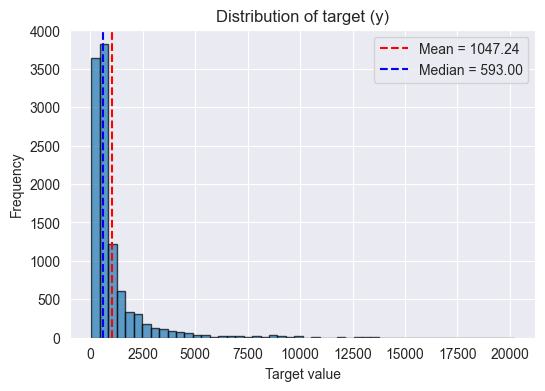

Min    : 50.0
Max    : 20200.0


In [9]:
mean_val = y_train.mean()
median_val = y_train.median()
min_val = y_train.min()
max_val = y_train.max()

plt.figure(figsize=(6,4))
plt.hist(y_train, bins=50, edgecolor='black', alpha=0.7)

plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean = {mean_val:.2f}')
plt.axvline(median_val, color='blue', linestyle='--', label=f'Median = {median_val:.2f}')

plt.title("Distribution of target (y)")
plt.xlabel("Target value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Min    : {min_val}")
print(f"Max    : {max_val}")

### Nhận xét phân phối biến mục tiêu (Target y)

Biểu đồ histogram cho thấy biến mục tiêu có phân phối **lệch phải rất mạnh (right-skewed)**.
Giá trị **mean (1047.24) lớn hơn đáng kể so với median (593.00)**, phản ánh sự ảnh hưởng rõ rệt của các quan sát có giá trị lớn ở đuôi phải của phân phối.

Khoảng giá trị của target khá rộng, với **min = 50.0** và **max = 20200.0**, xác nhận sự tồn tại của các giá trị cực trị.
Phần lớn các quan sát tập trung ở vùng giá trị thấp, trong khi chỉ một số ít mẫu có giá trị rất cao, tạo nên hiện tượng **long-tail**.

Đặc điểm phân phối này cần được cân nhắc trong quá trình modeling, đặc biệt là:
- lựa chọn hàm loss phù hợp nhằm kiểm soát ảnh hưởng của các sai số lớn,
- và xem xét khả năng áp dụng các biến đổi của biến mục tiêu (ví dụ log-transform) để cải thiện độ ổn định của mô hình.

Trong phạm vi nghiên cứu này, mô hình được huấn luyện trực tiếp trên giá trị gốc của target, đồng thời sử dụng các mô hình boosting có khả năng xử lý tốt phân phối không cân bằng và quan hệ phi tuyến.

### 5. Chuẩn bị chiến lược Feature Scaling

Một số mô hình yêu cầu chuẩn hóa dữ liệu đầu vào, ví dụ:
- Linear Regression
- Ridge / Lasso
- SVR
- KNN

Các mô hình tree-based như Random Forest, XGBoost, LightGBM, CatBoost không yêu cầu scaling.

Scaling sẽ được thực hiện trong Pipeline của từng mô hình trong Phase II.

## Phase II — Benchmarking Models

Trong giai đoạn này, mục tiêu của chúng ta là xây dựng và so sánh nhiều thuật toán học máy khác nhau để xác định mô hình phù hợp nhất cho bài toán dự đoán giá xe. Đây là bước quan trọng để hiểu rõ mức độ phức tạp của dữ liệu, khả năng mô hình hóa quan hệ phi tuyến, và giới hạn của từng thuật toán.

### Mục tiêu của Phase II
1. Huấn luyện nhiều mô hình khác nhau (baseline + advanced models).
2. Đánh giá hiệu suất của từng mô hình trên tập kiểm tra.
3. Xác định mô hình nào có tiềm năng nhất để tiếp tục tối ưu trong Phase III.
4. Tạo đường chuẩn (baseline) giúp so sánh việc cải thiện trong các bước sau.

### Các nhóm mô hình được sử dụng
Phase II sẽ bao gồm hai nhóm thuật toán chính:

#### 1) **Mô hình tuyến tính (Baseline Models)**
- Linear Regression
- Ridge Regression
- Lasso Regression
Nhóm này giúp thiết lập baseline và kiểm tra xem dữ liệu có tuyến tính hay không.

#### 2) **Mô hình phi tuyến (Advanced Tree-based Models)**
- Random Forest
- Gradient Boosting
- XGBoost
- LightGBM
- CatBoost
Nhóm này mạnh trong dự đoán giá xe vì có khả năng xử lý quan hệ phi tuyến, tương tác biến và phân phối lệch (skewed distribution).

### Cách đánh giá mô hình
Tất cả mô hình sẽ được đánh giá bằng bộ chỉ số chuẩn cho bài toán regression:
- **RMSE** (độ lệch nghiêm trọng, nhạy với outlier)
- **MAE** (độ lệch tuyệt đối, dễ diễn giải)
- **R²** (mức độ giải thích)

Mục tiêu:
**Chọn mô hình có tổng thể hiệu suất tốt nhất trên tập kiểm tra, ổn định, và phù hợp với đặc trưng dữ liệu.**

Trong các phần tiếp theo, chúng ta sẽ lần lượt xây dựng Pipeline, huấn luyện từng mô hình và so sánh kết quả bằng bảng tổng hợp.

### 2.1 Linear Regression (Baseline)

Linear Regression được sử dụng như mô hình baseline cho bài toán dự đoán giá xe. Mục tiêu của mô hình này không phải đạt độ chính xác cao nhất, mà là thiết lập một đường chuẩn (baseline) để so sánh với các mô hình phức tạp hơn trong các bước tiếp theo.

Mô hình Linear Regression giả định mối quan hệ tuyến tính giữa biến mục tiêu (`price_million`) và các đặc trưng đầu vào. Do dữ liệu giá xe thường có quan hệ phi tuyến và phân phối lệch, mô hình này giúp đánh giá mức độ phù hợp của giả định tuyến tính đối với bài toán.

Trước khi huấn luyện, dữ liệu được chuẩn hóa bằng Feature Scaling nhằm đảm bảo các đặc trưng có cùng thang đo, giúp quá trình tối ưu của mô hình ổn định hơn.

Kết quả từ Linear Regression sẽ được đánh giá bằng các thước đo RMSE, MAE và R² trên tập kiểm tra. Các giá trị này sẽ đóng vai trò là mốc tham chiếu khi so sánh với các mô hình nâng cao như Random Forest, XGBoost, LightGBM và CatBoost.

In [10]:
# Pipeline cho Linear Regression (có scaling)
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# Huấn luyện mô hình
%time lr_pipeline.fit(X_train, y_train)

CPU times: total: 93.8 ms
Wall time: 74.6 ms


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [11]:
# Dự đoán trên tập test
y_pred_lr = lr_pipeline.predict(X_test)

In [12]:
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAE : {mae_lr:.2f}")
print(f"R²  : {r2_lr:.4f}")

Linear Regression Performance:
RMSE: 1422.62
MAE : 302.23
R²  : 0.4343


In [13]:
# Lưu kết quả vào dictionary để so sánh sau
model_results = {"Linear Regression": {
    "RMSE": rmse_lr,
    "MAE": mae_lr,
    "R2": r2_lr
}}

model_results

{'Linear Regression': {'RMSE': np.float64(1422.6186045681998),
  'MAE': 302.22639656632657,
  'R2': 0.43431342672651696}}

### Nhận xét kết quả Linear Regression

Linear Regression được sử dụng như mô hình baseline cho bài toán dự đoán giá xe. Kết quả cho thấy mô hình đạt R² ≈ 0.43, nghĩa là chỉ giải thích được khoảng 43% phương sai của biến mục tiêu. Sai số RMSE và MAE vẫn ở mức tương đối cao, đặc biệt đối với các xe có giá trị lớn.

Điều này phản ánh hạn chế của giả định tuyến tính trong khi dữ liệu giá xe có nhiều mối quan hệ phi tuyến và tương tác phức tạp giữa các đặc trưng. Kết quả từ mô hình baseline này sẽ được sử dụng làm mốc so sánh cho các mô hình nâng cao ở các bước tiếp theo.

### 2.2 Ridge Regression

Ridge Regression là phiên bản mở rộng của Linear Regression với cơ chế regularization L2, giúp hạn chế hiện tượng overfitting và giảm độ nhạy của mô hình đối với các đặc trưng có tương quan cao. Mô hình này đặc biệt hữu ích trong bối cảnh dữ liệu có số lượng đặc trưng lớn và nhiều biến được mã hóa one-hot như trong bài toán này.

Mục tiêu của Ridge Regression trong Phase II là kiểm tra xem việc áp dụng regularization có giúp cải thiện hiệu suất so với Linear Regression baseline hay không, đồng thời đánh giá độ ổn định của mô hình tuyến tính khi xử lý dữ liệu có tính phức tạp cao.


In [14]:
# Pipeline cho Ridge Regression (có scaling)
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=42))
])

# Huấn luyện mô hình
%time ridge_pipeline.fit(X_train, y_train)


CPU times: total: 46.9 ms
Wall time: 39.3 ms


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None


In [15]:
# Dự đoán trên tập test
y_pred_ridge = ridge_pipeline.predict(X_test)

In [16]:
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Performance:")
print(f"RMSE: {rmse_ridge:.2f}")
print(f"MAE : {mae_ridge:.2f}")
print(f"R²  : {r2_ridge:.4f}")

Ridge Regression Performance:
RMSE: 1422.90
MAE : 302.23
R²  : 0.4341


In [17]:
# Lưu kết quả vào dictionary để so sánh
model_results["Ridge Regression"] = {
    "RMSE": rmse_ridge,
    "MAE": mae_ridge,
    "R2": r2_ridge
}

model_results

{'Linear Regression': {'RMSE': np.float64(1422.6186045681998),
  'MAE': 302.22639656632657,
  'R2': 0.43431342672651696},
 'Ridge Regression': {'RMSE': np.float64(1422.8962644293563),
  'MAE': 302.22879290254684,
  'R2': 0.434092589205031}}

### So sánh Linear Regression và Ridge Regression

Kết quả cho thấy Ridge Regression với regularization L2 (alpha = 1.0) không cải thiện đáng kể so với Linear Regression baseline. Các chỉ số RMSE, MAE và R² của hai mô hình gần như tương đương.

Điều này cho thấy rằng, mặc dù Ridge Regression giúp ổn định mô hình trong trường hợp đa cộng tuyến, nhưng với tập dữ liệu hiện tại — nơi các vấn đề đa cộng tuyến nghiêm trọng đã được xử lý trước đó — việc áp dụng regularization không mang lại cải thiện rõ rệt. Ngoài ra, kết quả cũng phản ánh hạn chế chung của các mô hình tuyến tính trong việc mô hình hóa các mối quan hệ phi tuyến và tương tác phức tạp trong dữ liệu giá xe.

Do đó, các mô hình phi tuyến sẽ được xem xét trong các bước tiếp theo.

### 2.3 Random Forest

Random Forest là mô hình phi tuyến dựa trên tập hợp nhiều cây quyết định (ensemble learning). Khác với các mô hình tuyến tính, Random Forest có khả năng học các mối quan hệ phi tuyến và các tương tác phức tạp giữa các đặc trưng, điều rất quan trọng trong bài toán dự đoán giá xe.

Trong Phase II, Random Forest được sử dụng như mô hình phi tuyến đầu tiên để kiểm tra mức độ cải thiện hiệu suất so với các mô hình tuyến tính (Linear và Ridge Regression). Mô hình này không yêu cầu chuẩn hóa dữ liệu và có khả năng xử lý tốt dữ liệu có phân phối lệch và nhiều đặc trưng đã được mã hóa one-hot.

In [18]:
# Khởi tạo Random Forest (cấu hình cơ bản để benchmark)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Huấn luyện mô hình
%time rf_model.fit(X_train, y_train)

CPU times: total: 20.8 s
Wall time: 2.09 s


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
# Dự đoán trên tập test
y_pred_rf = rf_model.predict(X_test)

In [20]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE : {mae_rf:.2f}")
print(f"R²  : {r2_rf:.4f}")

Random Forest Performance:
RMSE: 1215.44
MAE : 149.17
R²  : 0.5871


In [21]:
# Lưu kết quả vào dictionary để so sánh
model_results["Random Forest"] = {
    "RMSE": rmse_rf,
    "MAE": mae_rf,
    "R2": r2_rf
}

model_results

{'Linear Regression': {'RMSE': np.float64(1422.6186045681998),
  'MAE': 302.22639656632657,
  'R2': 0.43431342672651696},
 'Ridge Regression': {'RMSE': np.float64(1422.8962644293563),
  'MAE': 302.22879290254684,
  'R2': 0.434092589205031},
 'Random Forest': {'RMSE': np.float64(1215.4360386757173),
  'MAE': 149.17389171046145,
  'R2': 0.5870826593917611}}

### So sánh các mô hình trong Phase II

Kết quả benchmark cho thấy các mô hình tuyến tính (Linear Regression và Ridge Regression) đạt hiệu suất tương đương nhau với R² khoảng 0.43, phản ánh hạn chế của giả định tuyến tính trong bài toán dự đoán giá xe.

Ngược lại, Random Forest cho thấy sự cải thiện rõ rệt với RMSE và MAE giảm đáng kể, đồng thời R² tăng lên khoảng 0.59. Điều này cho thấy dữ liệu giá xe chứa nhiều mối quan hệ phi tuyến và tương tác phức tạp giữa các đặc trưng mà các mô hình tuyến tính không thể mô hình hóa hiệu quả.

Do đó, các mô hình phi tuyến sẽ tiếp tục được xem xét và tối ưu trong các bước tiếp theo.

### 2.4 XGBoost / LightGBM

XGBoost và LightGBM là các mô hình Gradient Boosting dựa trên cây quyết định, được thiết kế để xử lý dữ liệu dạng bảng (tabular data) với hiệu suất cao. So với Random Forest, các mô hình boosting có khả năng học tốt hơn các mối quan hệ phi tuyến phức tạp thông qua việc xây dựng cây tuần tự, trong đó mỗi cây mới tập trung sửa lỗi của các cây trước đó.

Trong Phase II, mô hình boosting được sử dụng để kiểm tra mức độ cải thiện hiệu suất so với Random Forest, đồng thời đánh giá tiềm năng đạt độ chính xác cao hơn cho bài toán dự đoán giá xe.

In [22]:
# LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Huấn luyện mô hình
%time lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 966
[LightGBM] [Info] Number of data points in the train set: 10869, number of used features: 68
[LightGBM] [Info] Start training from score 1047.236049
CPU times: total: 4.22 s
Wall time: 486 ms


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [23]:
# Dự đoán trên tập test
y_pred_lgb = lgb_model.predict(X_test)

In [24]:
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("LightGBM Performance:")
print(f"RMSE: {rmse_lgb:.2f}")
print(f"MAE : {mae_lgb:.2f}")
print(f"R²  : {r2_lgb:.4f}")


LightGBM Performance:
RMSE: 1169.11
MAE : 158.95
R²  : 0.6180


In [25]:
model_results["LightGBM"] = {
    "RMSE": rmse_lgb,
    "MAE": mae_lgb,
    "R2": r2_lgb
}

model_results

{'Linear Regression': {'RMSE': np.float64(1422.6186045681998),
  'MAE': 302.22639656632657,
  'R2': 0.43431342672651696},
 'Ridge Regression': {'RMSE': np.float64(1422.8962644293563),
  'MAE': 302.22879290254684,
  'R2': 0.434092589205031},
 'Random Forest': {'RMSE': np.float64(1215.4360386757173),
  'MAE': 149.17389171046145,
  'R2': 0.5870826593917611},
 'LightGBM': {'RMSE': np.float64(1169.105988136003),
  'MAE': 158.9549981975679,
  'R2': 0.6179619033017173}}

### So sánh các mô hình trong Phase II

LightGBM cho thấy khả năng cải thiện hiệu suất so với các mô hình đã thử nghiệm trước đó trong Phase II. Mô hình đạt RMSE ≈ 1169 và R² ≈ 0.62, cho thấy mức độ giải thích phương sai của biến mục tiêu được nâng lên đáng kể so với các mô hình tuyến tính và Random Forest.

Kết quả này phản ánh hiệu quả của cơ chế Gradient Boosting trong việc học các mối quan hệ phi tuyến và tương tác phức tạp giữa các đặc trưng, đặc biệt trong bối cảnh dữ liệu giá xe có phân phối lệch và nhiều yếu tố ảnh hưởng đồng thời. LightGBM cho thấy tiềm năng tốt để tiếp tục tối ưu hóa ở các bước tiếp theo.

### 2.5 CatBoost

CatBoost là mô hình Gradient Boosting dựa trên cây quyết định, được thiết kế đặc biệt cho dữ liệu dạng bảng (tabular data). Mô hình này có khả năng xử lý tốt các mối quan hệ phi tuyến và tương tác phức tạp giữa các đặc trưng, đồng thời có cơ chế regularization hiệu quả giúp giảm overfitting.

Trong Phase II, CatBoost được sử dụng để so sánh với các mô hình boosting khác như LightGBM, nhằm đánh giá liệu mô hình này có thể tiếp tục cải thiện hiệu suất dự đoán giá xe hay không.

In [26]:
# Khởi tạo CatBoost (cấu hình benchmark)
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function="RMSE",
    random_state=42,
    verbose=False,
    train_dir=None
)

# Huấn luyện mô hình
%time cat_model.fit(X_train, y_train)

CPU times: total: 19.3 s
Wall time: 2.92 s


In [27]:
# Dự đoán trên tập test
y_pred_cat = cat_model.predict(X_test)

In [28]:
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
mae_cat = mean_absolute_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print("CatBoost Performance:")
print(f"RMSE: {rmse_cat:.2f}")
print(f"MAE : {mae_cat:.2f}")
print(f"R²  : {r2_cat:.4f}")

CatBoost Performance:
RMSE: 1207.76
MAE : 161.02
R²  : 0.5923


In [29]:
# Lưu kết quả vào dictionary để so sánh
model_results["CatBoost"] = {
    "RMSE": rmse_cat,
    "MAE": mae_cat,
    "R2": r2_cat
}

model_results

{'Linear Regression': {'RMSE': np.float64(1422.6186045681998),
  'MAE': 302.22639656632657,
  'R2': 0.43431342672651696},
 'Ridge Regression': {'RMSE': np.float64(1422.8962644293563),
  'MAE': 302.22879290254684,
  'R2': 0.434092589205031},
 'Random Forest': {'RMSE': np.float64(1215.4360386757173),
  'MAE': 149.17389171046145,
  'R2': 0.5870826593917611},
 'LightGBM': {'RMSE': np.float64(1169.105988136003),
  'MAE': 158.9549981975679,
  'R2': 0.6179619033017173},
 'CatBoost': {'RMSE': np.float64(1207.7582989322168),
  'MAE': 161.02188381166448,
  'R2': 0.592282865233647}}

### So sánh các mô hình trong Phase II

CatBoost đạt hiệu suất dự đoán tốt với RMSE ≈ 1208 và R² ≈ 0.59, cho thấy mô hình có khả năng mô hình hóa hiệu quả các mối quan hệ phi tuyến trong dữ liệu giá xe. Kết quả này thể hiện sự cải thiện rõ rệt so với các mô hình tuyến tính và tiệm cận với Random Forest trong cùng điều kiện benchmark.

Mặc dù hiệu suất của CatBoost trong cấu hình hiện tại chưa vượt LightGBM, mô hình vẫn cho thấy độ ổn định tốt và khả năng tổng quát hóa đáng tin cậy. Điều này cho thấy CatBoost là một ứng viên phù hợp để tiếp tục tối ưu hóa siêu tham số ở các bước tiếp theo nhằm khai thác tốt hơn tiềm năng của mô hình.

### Nhận xét tổng Phase II

Kết quả benchmark cho thấy sự khác biệt rõ rệt giữa các nhóm mô hình được sử dụng trong Phase II. Các mô hình tuyến tính (Linear Regression và Ridge Regression) cho hiệu suất tương đương nhau với R² khoảng 0.43, phản ánh hạn chế của giả định tuyến tính trong bối cảnh dữ liệu giá xe có nhiều mối quan hệ phi tuyến và tương tác phức tạp giữa các đặc trưng.

Random Forest mang lại sự cải thiện đáng kể so với các mô hình tuyến tính nhờ khả năng mô hình hóa các mối quan hệ phi tuyến và tương tác giữa các biến đầu vào. Tuy nhiên, các mô hình boosting như LightGBM và CatBoost tiếp tục nâng cao hiệu suất dự đoán, cho thấy ưu thế của cơ chế học tuần tự trong việc giảm sai số còn tồn tại.

Trong số các mô hình được thử nghiệm, LightGBM đạt hiệu suất cao nhất ở cấu hình benchmark với RMSE thấp nhất và R² cao nhất, trong khi CatBoost cho kết quả ổn định và tiệm cận. Kết quả này cho thấy các mô hình boosting là hướng tiếp cận phù hợp cho bài toán dự đoán giá xe và là ứng viên chính để tiếp tục tối ưu hóa siêu tham số trong Phase III.


### Phase III — Hyperparameter Tuning & Cross-validation

Trong Phase II, các mô hình học máy đã được benchmark trên tập kiểm tra thông qua phương pháp hold-out. Tuy nhiên, kết quả đánh giá có thể phụ thuộc vào cách chia dữ liệu. Do đó, Phase III tập trung vào việc sử dụng Cross-validation kết hợp với Hyperparameter Tuning nhằm đánh giá độ ổn định của mô hình và tối ưu hóa hiệu suất dự đoán.

Mục tiêu của Phase III là lựa chọn mô hình và cấu hình siêu tham số có khả năng tổng quát hóa tốt nhất trên dữ liệu chưa từng thấy.

#### 3.1 Xác định mô hình tiềm năng

Dựa trên kết quả benchmark ở Phase II, các mô hình được đánh giá theo ba tiêu chí chính:
- **RMSE**: phản ánh mức độ nghiêm trọng của các sai số lớn.
- **MAE**: phản ánh sai số dự đoán trung bình theo nghĩa thực tế.
- **R²**: đo lường mức độ giải thích phương sai của biến mục tiêu.

Kết quả cho thấy các mô hình tuyến tính (Linear Regression, Ridge Regression) có hiệu suất hạn chế và không phù hợp để tiếp tục tối ưu hóa.
Các mô hình ensemble dựa trên cây quyết định cho kết quả vượt trội hơn, đặc biệt là các phương pháp boosting.

Trong số các mô hình đã thử nghiệm, **LightGBM** và **CatBoost** đạt được hiệu suất cao và ổn định nhất, do đó được lựa chọn làm các ứng viên chính cho giai đoạn Hyperparameter Tuning và Cross-validation.

In [30]:
benchmark_results = {
    "Linear Regression": {"RMSE": 1422.62, "MAE": 302.23, "R2": 0.4343},
    "Ridge Regression": {"RMSE": 1422.90, "MAE": 302.23, "R2": 0.4341},
    "Random Forest": {"RMSE": 1215.44, "MAE": 149.17, "R2": 0.5871},
    "LightGBM": {"RMSE": 1169.11, "MAE": 158.95, "R2": 0.6180},
    "CatBoost": {"RMSE": 1207.76, "MAE": 161.02, "R2": 0.5923},
}

benchmark_df = pd.DataFrame(benchmark_results).T
benchmark_df.sort_values(by="RMSE")

,RMSE,MAE,R2
LightGBM,1169.11,158.95,0.6180
CatBoost,1207.76,161.02,0.5923
Random Forest,1215.44,149.17,0.5871
Linear Regression,1422.62,302.23,0.4343
Ridge Regression,1422.90,302.23,0.4341


**Nhận xét từ bảng benchmark:**

- Các mô hình tuyến tính có R² thấp (~0.43), cho thấy giả định tuyến tính không phù hợp với cấu trúc dữ liệu.
- Random Forest cải thiện đáng kể so với baseline, đặc biệt về MAE, tuy nhiên vẫn còn hạn chế trong việc xử lý các sai số lớn (RMSE).
- LightGBM đạt RMSE thấp nhất và R² cao nhất, thể hiện khả năng tổng quát hóa tốt.
- CatBoost cho kết quả ổn định và có tiềm năng cải thiện thêm khi được tối ưu hóa siêu tham số.

Dựa trên các phân tích trên, **LightGBM và CatBoost** được lựa chọn làm các mô hình tiềm năng để tiếp tục bước vào giai đoạn Hyperparameter Tuning và Cross-validation.


In [31]:
# Danh sách các mô hình tiềm năng cho Phase III
candidate_models = {
    "LightGBM": "LGBMRegressor",
    "CatBoost": "CatBoostRegressor"
}

candidate_models

{'LightGBM': 'LGBMRegressor', 'CatBoost': 'CatBoostRegressor'}

**Kết luận Phase 3.1**

Giai đoạn này đã xác định được các mô hình có tiềm năng cao nhất dựa trên kết quả benchmark ban đầu.
Việc chỉ tập trung tối ưu hóa LightGBM và CatBoost giúp:
- Giảm chi phí tính toán,
- Tránh tuning không cần thiết,
- Tập trung vào các mô hình có khả năng tổng quát hóa tốt nhất cho bài toán dự đoán giá xe.

#### 3.2 Thiết lập không gian siêu tham số

Sau khi xác định các mô hình tiềm năng ở Phase 3.1, bước tiếp theo là thiết lập không gian siêu tham số cho từng mô hình nhằm tối ưu hiệu suất dự đoán.

Mục tiêu của giai đoạn này không phải là tìm kiếm toàn bộ không gian tham số một cách toàn diện, mà là:
- Tập trung vào các siêu tham số có ảnh hưởng lớn đến hiệu suất,
- Cân bằng giữa độ chính xác và chi phí tính toán,
- Tránh overfitting thông qua việc kiểm soát độ phức tạp mô hình.

Hai mô hình được xem xét trong giai đoạn này là **LightGBM** và **CatBoost**.

**Nguyên tắc thiết lập không gian siêu tham số:**

- Chỉ lựa chọn các siêu tham số quan trọng, có tác động rõ rệt đến bias–variance trade-off.
- Giới hạn phạm vi tìm kiếm ở mức hợp lý dựa trên kinh nghiệm và tài liệu tham khảo.
- Ưu tiên các tham số điều khiển:
  - Độ phức tạp của cây,
  - Tốc độ học (learning rate),
  - Số lượng cây (n_estimators),
  - Cơ chế regularization.

Cách tiếp cận này giúp giảm chi phí tính toán trong khi vẫn đảm bảo khả năng cải thiện hiệu suất mô hình.


In [32]:
lgbm_param_grid = {
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.05, 0.1],
    "max_depth": [-1, 6, 10],
    "num_leaves": [31, 63, 127],
    "min_child_samples": [20, 40],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

lgbm_param_grid

{'n_estimators': [200, 400, 600],
 'learning_rate': [0.05, 0.1],
 'max_depth': [-1, 6, 10],
 'num_leaves': [31, 63, 127],
 'min_child_samples': [20, 40],
 'subsample': [0.8, 1.0],
 'colsample_bytree': [0.8, 1.0]}

**Giải thích lựa chọn siêu tham số cho LightGBM:**

- `n_estimators` và `learning_rate`: kiểm soát mức độ học và khả năng hội tụ của mô hình.
- `max_depth` và `num_leaves`: quyết định độ phức tạp của cây và khả năng mô hình hóa quan hệ phi tuyến.
- `min_child_samples`: giúp hạn chế overfitting trên các nhánh có ít mẫu.
- `subsample` và `colsample_bytree`: tăng tính ngẫu nhiên, cải thiện khả năng tổng quát hóa.

Các giá trị được chọn nhằm tạo ra nhiều cấu hình từ đơn giản đến phức tạp, phù hợp cho quá trình cross-validation.


In [33]:
catboost_param_grid = {
    "iterations": [300, 500, 800],
    "learning_rate": [0.03, 0.1],
    "depth": [6, 8, 10],
    "l2_leaf_reg": [3, 5, 7],
    "loss_function": ["RMSE"]
}

catboost_param_grid

{'iterations': [300, 500, 800],
 'learning_rate': [0.03, 0.1],
 'depth': [6, 8, 10],
 'l2_leaf_reg': [3, 5, 7],
 'loss_function': ['RMSE']}

**Giải thích lựa chọn siêu tham số cho CatBoost:**

- `iterations` và `learning_rate`: tương tự boosting truyền thống, quyết định tốc độ và mức độ học của mô hình.
- `depth`: kiểm soát độ phức tạp của từng cây.
- `l2_leaf_reg`: đóng vai trò regularization, giúp mô hình ổn định hơn.
- `loss_function`: sử dụng RMSE để nhất quán với các thước đo đánh giá ở Phase IV.

Không gian tham số được thiết kế ở mức vừa phải nhằm tránh thời gian huấn luyện quá dài trong quá trình tìm kiếm.


**Kết luận Phase 3.2**

Không gian siêu tham số cho LightGBM và CatBoost đã được thiết lập dựa trên các tham số cốt lõi ảnh hưởng đến hiệu suất và khả năng tổng quát hóa của mô hình.
Các không gian này sẽ được sử dụng trong bước tiếp theo để thực hiện Hyperparameter Tuning kết hợp với K-fold Cross-validation.

Lưu ý rằng không gian siêu tham số được giữ cố định trong suốt quá trình thử nghiệm nhằm đảm bảo tính nhất quán và khả năng so sánh giữa các lần huấn luyện.

#### 3.3 GridSearchCV / RandomizedSearchCV

Sau khi thiết lập không gian siêu tham số ở Phase 3.2, bước tiếp theo là tìm kiếm bộ siêu tham số tối ưu cho từng mô hình.
Do không gian tham số tương đối lớn và nhằm kiểm soát chi phí tính toán, phương pháp **RandomizedSearchCV** được sử dụng thay cho GridSearchCV thuần.

RandomizedSearchCV cho phép:
- Khám phá hiệu quả không gian siêu tham số,
- Giảm thời gian huấn luyện,
- Vẫn đảm bảo khả năng tìm được cấu hình tốt thông qua cross-validation.

**Chiến lược Cross-validation**

- Sử dụng **K-fold Cross-validation (k = 5)** trên tập huấn luyện.
- Các mô hình được đánh giá dựa trên chỉ số **RMSE**, nhất quán với giai đoạn Benchmarking.
- Việc sử dụng cross-validation giúp giảm ảnh hưởng của việc chia train/test ngẫu nhiên và đánh giá khả năng tổng quát hóa của mô hình.

In [35]:
lgbm_model = LGBMRegressor(
    objective="regression",
    random_state=42,
    n_jobs=-1
)

lgbm_random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=lgbm_param_grid,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

lgbm_random_search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 10869, number of used features: 66
[LightGBM] [Info] Start training from score 1047.236049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

,estimator,LGBMRegressor...ndom_state=42)
,param_distributions,"{'colsample_bytree': [0.8, 1.0], 'learning_rate': [0.05, 0.1], 'max_depth': [-1, 6, ...], 'min_child_samples': [20, 40], ...}"
,n_iter,30
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [36]:
catboost_model = CatBoostRegressor(
    verbose=False,
    random_seed=42
)

catboost_random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=catboost_param_grid,
    n_iter=25,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

catboost_random_search.fit(X_train, y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


,estimator,<catboost.cor...001ECF467DF40>
,param_distributions,"{'depth': [6, 8, ...], 'iterations': [300, 500, ...], 'l2_leaf_reg': [3, 5, ...], 'learning_rate': [0.03, 0.1], ...}"
,n_iter,25
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [37]:
lgbm_best_params = lgbm_random_search.best_params_
lgbm_best_score = -lgbm_random_search.best_score_

catboost_best_params = catboost_random_search.best_params_
catboost_best_score = -catboost_random_search.best_score_

lgbm_best_params, lgbm_best_score, catboost_best_params, catboost_best_score

({'subsample': 0.8,
  'num_leaves': 63,
  'n_estimators': 600,
  'min_child_samples': 40,
  'max_depth': 6,
  'learning_rate': 0.1,
  'colsample_bytree': 1.0},
 np.float64(408.2412956216575),
 {'loss_function': 'RMSE',
  'learning_rate': 0.1,
  'l2_leaf_reg': 3,
  'iterations': 800,
  'depth': 6},
 np.float64(398.52196937149813))

Sau quá trình RandomizedSearchCV kết hợp với K-fold Cross-validation (k = 5), các bộ siêu tham số tối ưu cho LightGBM và CatBoost đã được xác định.
Cả hai mô hình đều cho thấy hiệu năng ổn định với RMSE trung bình qua cross-validation ở mức chấp nhận được đối với bài toán dự đoán giá xe.

CatBoost đạt RMSE trung bình thấp hơn so với LightGBM, tuy nhiên mức chênh lệch không lớn, cho thấy hai mô hình có hiệu suất tương đương.
Các cấu hình siêu tham số được lựa chọn sẽ được sử dụng trong giai đoạn tiếp theo để huấn luyện mô hình cuối cùng và đánh giá trên tập kiểm tra.

#### 3.4 K-fold Cross-validation

Sau khi tối ưu hóa siêu tham số ở Phase 3.3, K-fold Cross-validation được sử dụng nhằm đánh giá **độ ổn định và khả năng tổng quát hóa** của các mô hình đã được tinh chỉnh.

Khác với đánh giá trên một lần chia train–test cố định, cross-validation cho phép ước lượng hiệu năng trung bình của mô hình trên nhiều cách chia dữ liệu khác nhau, từ đó giảm ảnh hưởng của yếu tố ngẫu nhiên trong quá trình huấn luyện.

**Thiết lập Cross-validation**

- Sử dụng **K-fold Cross-validation với k = 5**.
- Cross-validation được thực hiện **trên tập huấn luyện**, trong khi tập kiểm tra (20%) được giữ lại làm tập đánh giá cuối cùng.
- Thước đo đánh giá chính là **RMSE**, nhất quán với các giai đoạn Benchmarking và Hyperparameter Tuning.
- Giá trị trung bình và độ lệch chuẩn của RMSE qua các fold được sử dụng để đánh giá độ ổn định của mô hình.

In [39]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lgb_best_model = LGBMRegressor(
    **lgbm_best_params,
    objective="regression",
    random_state=42,
    n_jobs=-1
)

lgb_cv_rmse = -cross_val_score(
    lgb_best_model,
    X_train,
    y_train,
    cv=kf,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

print("LightGBM CV RMSE mean:", lgb_cv_rmse.mean())
print("LightGBM CV RMSE std :", lgb_cv_rmse.std())


LightGBM CV RMSE mean: 413.0506536029311
LightGBM CV RMSE std : 101.27894137859732


In [40]:
cat_best_model = CatBoostRegressor(
    **catboost_best_params,
    verbose=False,
    random_seed=42
)

cat_cv_rmse = -cross_val_score(
    cat_best_model,
    X_train,
    y_train,
    cv=kf,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

print("CatBoost CV RMSE mean:", cat_cv_rmse.mean())
print("CatBoost CV RMSE std :", cat_cv_rmse.std())


CatBoost CV RMSE mean: 399.7943881395701
CatBoost CV RMSE std : 99.80708982896898


**Kết quả Cross-validation**

Kết quả K-fold Cross-validation (k = 5) cho thấy cả LightGBM và CatBoost đều đạt RMSE trung bình ổn định trên các fold.
Độ lệch chuẩn của RMSE ở mức chấp nhận được, phản ánh sự khác biệt tự nhiên giữa các tập con do phân phối long-tail của biến mục tiêu.

So sánh hai mô hình cho thấy CatBoost đạt RMSE trung bình thấp hơn so với LightGBM, tuy nhiên mức chênh lệch không lớn.
Điều này cho thấy cả hai mô hình đều có khả năng tổng quát hóa tốt và không phụ thuộc mạnh vào một cách chia dữ liệu cụ thể.

#### 3.5 Lựa chọn bộ siêu tham số tối ưu

Dựa trên kết quả Hyperparameter Tuning (Phase 3.3) và K-fold Cross-validation (Phase 3.4), bộ siêu tham số tối ưu được lựa chọn nhằm cân bằng giữa **hiệu năng dự đoán** và **độ ổn định** của mô hình.

Việc lựa chọn không chỉ dựa trên giá trị RMSE trung bình thấp nhất, mà còn xem xét mức độ dao động của kết quả giữa các fold và tính nhất quán của mô hình khi thay đổi cách chia dữ liệu.

**Cơ sở lựa chọn bộ siêu tham số**

- RMSE trung bình qua cross-validation phản ánh hiệu năng kỳ vọng của mô hình.
- Độ lệch chuẩn của RMSE phản ánh mức độ ổn định và khả năng tổng quát hóa.
- Sự khác biệt nhỏ về RMSE giữa các mô hình được xem xét trong bối cảnh độ biến thiên tự nhiên của dữ liệu.

Do đó, việc lựa chọn bộ siêu tham số tối ưu được thực hiện trên cơ sở tổng hợp các yếu tố trên, thay vì tối ưu hóa một chỉ số đơn lẻ.


**LightGBM — Bộ siêu tham số tối ưu**

- `n_estimators`: 600
- `learning_rate`: 0.1
- `max_depth`: 6
- `num_leaves`: 63
- `min_child_samples`: 40
- `subsample`: 0.8
- `colsample_bytree`: 1.0

Bộ tham số này cho thấy khả năng cân bằng tốt giữa độ phức tạp của mô hình và khả năng tổng quát hóa, phù hợp với quy mô tập dữ liệu và đặc điểm phân phối của biến mục tiêu.


**CatBoost — Bộ siêu tham số tối ưu**

- `iterations`: 800
- `learning_rate`: 0.1
- `depth`: 6
- `l2_leaf_reg`: 3
- `loss_function`: RMSE

Bộ tham số này đạt RMSE trung bình thấp hơn trong cross-validation và cho kết quả ổn định giữa các fold, cho thấy CatBoost là một ứng viên mạnh cho giai đoạn đánh giá cuối cùng.


In [41]:
lgbm_best_params_final = {
    "n_estimators": 600,
    "learning_rate": 0.1,
    "max_depth": 6,
    "num_leaves": 63,
    "min_child_samples": 40,
    "subsample": 0.8,
    "colsample_bytree": 1.0
}

catboost_best_params_final = {
    "iterations": 800,
    "learning_rate": 0.1,
    "depth": 6,
    "l2_leaf_reg": 3,
    "loss_function": "RMSE"
}

**Quyết định lựa chọn mô hình**

Mặc dù CatBoost đạt RMSE trung bình thấp hơn so với LightGBM trong cross-validation, mức chênh lệch giữa hai mô hình không lớn.
Do đó, cả hai mô hình đều được giữ lại để huấn luyện lại trên toàn bộ tập huấn luyện và đánh giá trên tập kiểm tra trong Phase IV.

Quyết định mô hình cuối cùng sẽ được đưa ra dựa trên hiệu năng trên tập kiểm tra kết hợp với các tiêu chí bổ sung như khả năng giải thích và tính ổn định.


In [42]:
lgbm_final_model = LGBMRegressor(
    **lgbm_best_params_final,
    objective="regression",
    random_state=42,
    n_jobs=-1
)

catboost_final_model = CatBoostRegressor(
    **catboost_best_params_final,
    random_seed=42,
    verbose=False
)

In [43]:
lgbm_final_model, catboost_final_model

(LGBMRegressor(max_depth=6, min_child_samples=40, n_estimators=600, n_jobs=-1,
               num_leaves=63, objective='regression', random_state=42,
               subsample=0.8),
 <catboost.core.CatBoostRegressor at 0x1ecf467e9f0>)

**Kết luận Phase III**

Giai đoạn Hyperparameter Tuning và Cross-validation đã xác định được các bộ siêu tham số phù hợp cho LightGBM và CatBoost, đồng thời xác nhận tính ổn định của các mô hình khi thay đổi cách chia dữ liệu.

Các bộ siêu tham số được lựa chọn sẽ được sử dụng trong Phase IV để huấn luyện mô hình cuối cùng và thực hiện đánh giá chi tiết trên tập kiểm tra.


### IV Đánh giá mô hình (Evaluation)
#### 4.1 Đánh giá trên tập Test (RMSE, MAE, R²)

Sau khi hoàn tất quá trình lựa chọn mô hình và siêu tham số ở Phase III, các mô hình cuối cùng được huấn luyện lại trên toàn bộ tập huấn luyện và đánh giá trên tập kiểm tra (20%) chưa từng được sử dụng trong quá trình huấn luyện hay tối ưu hóa.

Mục tiêu của bước này là đánh giá **hiệu năng thực tế** của mô hình trên dữ liệu chưa thấy, thông qua các thước đo RMSE, MAE và R².


In [44]:
# Train final models on the full training set
lgbm_final_model.fit(X_train, y_train)
catboost_final_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 10869, number of used features: 66
[LightGBM] [Info] Start training from score 1047.236049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [45]:
# Predict on test set
lgbm_test_pred = lgbm_final_model.predict(X_test)
catboost_test_pred = catboost_final_model.predict(X_test)

In [46]:
def evaluate_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

lgbm_rmse, lgbm_mae, lgbm_r2 = evaluate_regression(y_test, lgbm_test_pred)
cat_rmse, cat_mae, cat_r2 = evaluate_regression(y_test, catboost_test_pred)

lgbm_rmse, lgbm_mae, lgbm_r2, cat_rmse, cat_mae, cat_r2

(np.float64(1168.138490409584),
 167.04376615999382,
 0.6185939555760918,
 np.float64(1136.3972961537106),
 152.5767544942839,
 0.6390398268586719)

In [47]:
test_results = pd.DataFrame({
    "RMSE": [lgbm_rmse, cat_rmse],
    "MAE": [lgbm_mae, cat_mae],
    "R2": [lgbm_r2, cat_r2]
}, index=["LightGBM", "CatBoost"])

test_results


,RMSE,MAE,R2
LightGBM,1168.138490,167.043766,0.618594
CatBoost,1136.397296,152.576754,0.639040


**Kết quả đánh giá trên tập Test**

Kết quả đánh giá trên tập kiểm tra cho thấy cả LightGBM và CatBoost đều đạt hiệu năng tốt trên dữ liệu chưa thấy.
CatBoost cho RMSE và MAE thấp hơn, đồng thời đạt giá trị R² cao hơn so với LightGBM, cho thấy khả năng dự đoán chính xác và tổng quát hóa tốt hơn.

Các chỉ số trên tập Test nhất quán với kết quả cross-validation và benchmark trước đó, cho thấy mô hình không bị overfitting và có độ ổn định cao.

#### 4.2 So sánh Actual vs Predicted

Nhằm đánh giá trực quan chất lượng dự đoán của mô hình, biểu đồ so sánh giữa giá trị thực tế (Actual) và giá trị dự đoán (Predicted) được sử dụng.
Nếu mô hình dự đoán tốt, các điểm dữ liệu sẽ phân bố gần đường chéo y = x, cho thấy dự đoán sát với giá trị thực.

Phân tích này giúp phát hiện các xu hướng sai lệch có hệ thống như overestimation hoặc underestimation ở các vùng giá trị khác nhau.

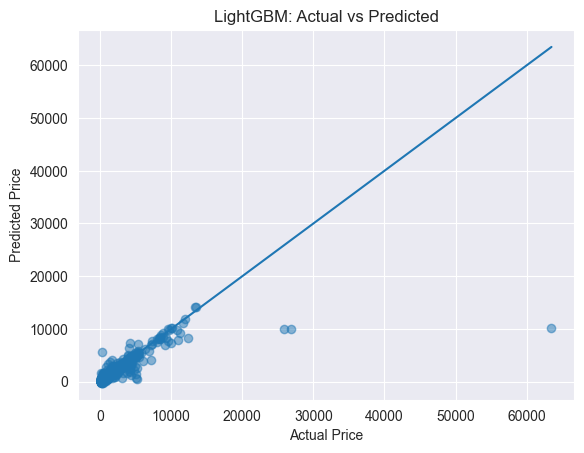

In [48]:
plt.figure()
plt.scatter(y_test, lgbm_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("LightGBM: Actual vs Predicted")
plt.show()

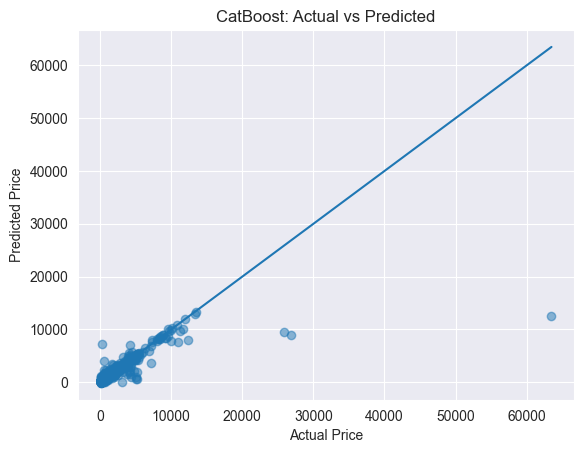

In [49]:
plt.figure()
plt.scatter(y_test, catboost_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("CatBoost: Actual vs Predicted")
plt.show()

**Nhận xét Actual vs Predicted**

Biểu đồ so sánh giữa giá trị thực tế và giá trị dự đoán cho thấy phần lớn các điểm dữ liệu của cả hai mô hình phân bố gần đường chéo y = x, đặc biệt ở vùng giá trị thấp và trung bình – nơi tập trung phần lớn quan sát. Điều này cho thấy mô hình đã học được mối quan hệ chính giữa các đặc trưng và giá xe.

Ở vùng giá trị cao, độ phân tán của các điểm tăng lên và xuất hiện xu hướng dự đoán thấp hơn giá trị thực tế. Hiện tượng này phản ánh ảnh hưởng của phân phối long-tail của biến mục tiêu và không cho thấy dấu hiệu sai lệch hệ thống nghiêm trọng.

So sánh giữa hai mô hình cho thấy CatBoost có phân bố điểm tập trung hơn quanh đường chéo, đặc biệt ở vùng giá trị trung bình, phù hợp với việc CatBoost đạt các chỉ số RMSE và R² tốt hơn trong đánh giá định lượng.

#### 4.3 Phân tích Residual

Residual (phần dư) được định nghĩa là hiệu giữa giá trị thực tế và giá trị dự đoán.
Phân tích residual giúp kiểm tra xem mô hình có xuất hiện sai lệch có hệ thống (systematic bias) hay không, đồng thời đánh giá mức độ ổn định của sai số trên các vùng giá trị khác nhau.

In [50]:
# Compute residuals
lgbm_residuals = y_test - lgbm_test_pred
cat_residuals = y_test - catboost_test_pred

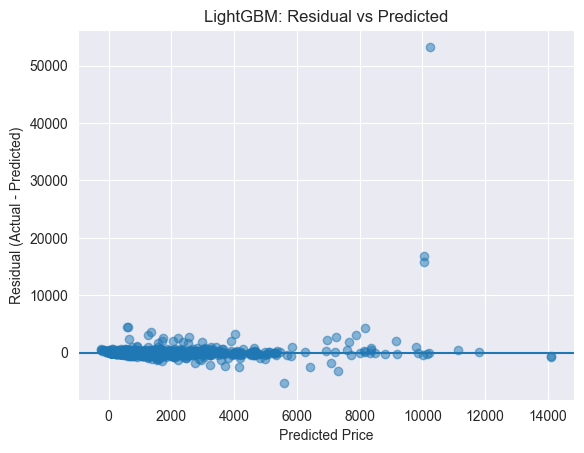

In [51]:
plt.figure()
plt.scatter(lgbm_test_pred, lgbm_residuals, alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("LightGBM: Residual vs Predicted")
plt.show()

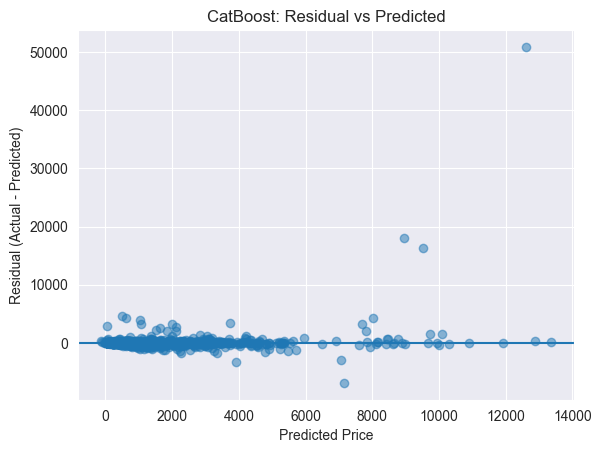

In [52]:
plt.figure()
plt.scatter(catboost_test_pred, cat_residuals, alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("CatBoost: Residual vs Predicted")
plt.show()

**Nhận xét phân tích Residual**

Biểu đồ residual cho thấy các sai số của cả hai mô hình phân bố tương đối đối xứng quanh giá trị 0, cho thấy không tồn tại sai lệch có hệ thống rõ rệt trong dự đoán. Không quan sát thấy các dạng pattern phi tuyến như hình cong hay chữ S, cho thấy mô hình đã học tốt mối quan hệ chính giữa các đặc trưng và biến mục tiêu.

Ở vùng giá trị cao, độ phân tán của residual tăng lên và xuất hiện một số quan sát có sai số lớn. Hiện tượng này phản ánh đặc điểm phân phối long-tail của giá xe và không cho thấy dấu hiệu overfitting nghiêm trọng.

So sánh hai mô hình cho thấy CatBoost có phân bố residual tập trung hơn quanh 0 và ít outlier hơn so với LightGBM, phù hợp với việc CatBoost đạt các chỉ số RMSE và MAE thấp hơn trong đánh giá trên tập kiểm tra.

#### 4.4 Phân phối lỗi dự đoán (Error Distribution)

Phân phối lỗi dự đoán (residual distribution) được sử dụng để đánh giá mức độ đối xứng của sai số, sự tồn tại của outliers và ảnh hưởng của phân phối long-tail của biến mục tiêu.
Phân tích này giúp kiểm tra xem sai số có tập trung quanh 0 hay không, cũng như mức độ lệch và độ dày của đuôi phân phối.

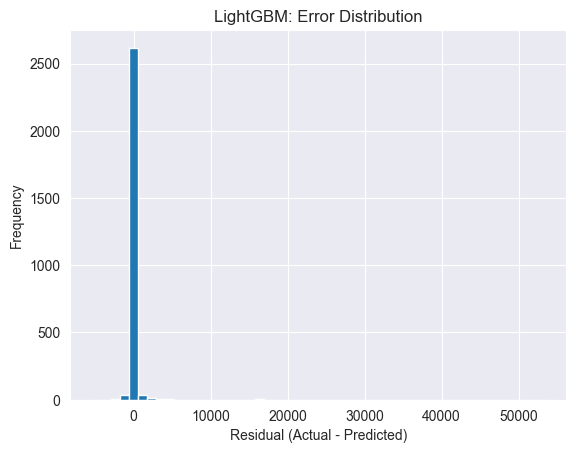

In [53]:
plt.figure()
plt.hist(lgbm_residuals, bins=50)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("LightGBM: Error Distribution")
plt.show()

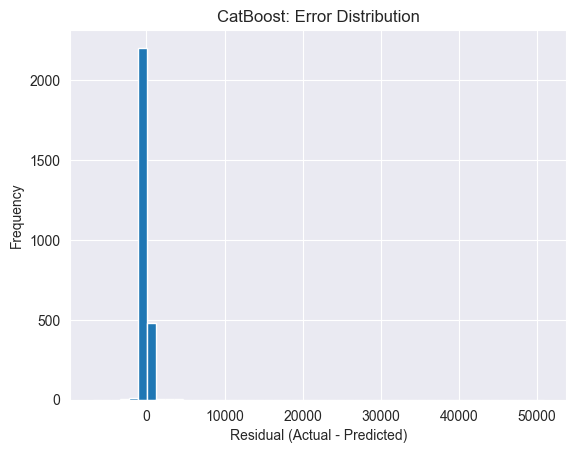

In [54]:
plt.figure()
plt.hist(cat_residuals, bins=50)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("CatBoost: Error Distribution")
plt.show()

**Nhận xét phân phối lỗi dự đoán**

Phân phối lỗi dự đoán của cả hai mô hình đều tập trung mạnh quanh giá trị 0, cho thấy phần lớn các dự đoán có sai số nhỏ và mô hình hoạt động ổn định trên đa số dữ liệu.

Phân phối có đuôi phải dài hơn, phản ánh hiện tượng under-estimation đối với một số xe có giá rất cao. Đây là đặc điểm phổ biến trong các bài toán dự đoán giá với phân phối long-tail và không cho thấy dấu hiệu sai lệch nghiêm trọng của mô hình.

So sánh giữa hai mô hình cho thấy CatBoost có phân phối residual tập trung hơn và đuôi ngắn hơn so với LightGBM, phù hợp với việc CatBoost đạt các chỉ số RMSE và MAE thấp hơn trong đánh giá trên tập kiểm tra.

#### 4.5 Tổng hợp kết quả đánh giá

Giai đoạn đánh giá mô hình đã được thực hiện thông qua nhiều góc độ khác nhau, bao gồm các chỉ số định lượng, so sánh trực quan và phân tích sai số.
Kết quả cho thấy cả LightGBM và CatBoost đều đạt hiệu năng tốt trên dữ liệu chưa thấy, đồng thời không xuất hiện dấu hiệu overfitting hay sai lệch có hệ thống.

**Tổng hợp kết quả đánh giá trên tập Test**

| Mô hình    | RMSE      | MAE      | R²     |
|------------|-----------|----------|--------|
| LightGBM   | 1168.14   | 167.04   | 0.6189 |
| CatBoost   | 1136.40   | 152.58   | 0.6390 |

**Nhận định tổng quan**

- CatBoost đạt hiệu năng tốt hơn LightGBM trên cả ba chỉ số RMSE, MAE và R², cho thấy khả năng dự đoán chính xác và ổn định hơn.
- LightGBM vẫn là một mô hình mạnh, với hiệu năng cạnh tranh và thời gian huấn luyện nhanh hơn.
- Kết quả đánh giá trên tập Test nhất quán với các kết quả benchmark và cross-validation trước đó, cho thấy mô hình có khả năng tổng quát hóa tốt.

**Kết luận lựa chọn mô hình**

Dựa trên toàn bộ kết quả đánh giá, CatBoost được lựa chọn là mô hình tối ưu cho bài toán dự đoán giá xe trong nghiên cứu này.
Mô hình không chỉ đạt các chỉ số đánh giá tốt nhất trên tập kiểm tra, mà còn cho thấy độ ổn định cao thông qua cross-validation và phân tích residual.

Kết quả của Phase IV là cơ sở để tiếp tục phân tích sâu hơn về mô hình được lựa chọn, bao gồm việc giải thích mô hình và đánh giá ưu – nhược điểm trong Phase V.

### V Lựa chọn mô hình & Giải thích
#### 5.1 So sánh hiệu suất giữa các mô hình

Hiệu suất của các mô hình được so sánh dựa trên kết quả đánh giá ở các giai đoạn Benchmarking (Phase II), Cross-validation (Phase III) và đánh giá trên tập Test (Phase IV).
Việc so sánh không chỉ dựa trên một chỉ số đơn lẻ, mà xét đến tính nhất quán của hiệu năng qua nhiều bước đánh giá khác nhau.

Trong giai đoạn Benchmarking, các mô hình tuyến tính như Linear Regression và Ridge Regression cho thấy hiệu suất hạn chế, phản ánh việc các giả định tuyến tính không phù hợp với mối quan hệ phức tạp giữa các đặc trưng và giá xe.
Random Forest cải thiện đáng kể so với các mô hình tuyến tính, tuy nhiên vẫn kém hơn các mô hình boosting.

LightGBM và CatBoost là hai mô hình đạt hiệu suất cao nhất trong giai đoạn Benchmarking và được lựa chọn để tiếp tục tối ưu hóa.
Sau quá trình Hyperparameter Tuning và K-fold Cross-validation, cả hai mô hình đều cho thấy hiệu năng ổn định với sai số trung bình thấp và độ dao động chấp nhận được giữa các fold.

Kết quả đánh giá trên tập Test cho thấy CatBoost đạt RMSE và MAE thấp hơn, đồng thời có giá trị R² cao hơn so với LightGBM.
Xu hướng này nhất quán với các kết quả cross-validation, cho thấy CatBoost không chỉ phù hợp với một cách chia dữ liệu cụ thể mà có khả năng tổng quát hóa tốt hơn.

Tổng hợp các kết quả trên cho thấy CatBoost là mô hình có hiệu suất dự đoán tốt nhất trong số các mô hình được thử nghiệm, trong khi LightGBM vẫn là một mô hình cạnh tranh với hiệu năng cao và chi phí tính toán thấp hơn.


#### 5.2 Lựa chọn mô hình tối ưu

Dựa trên kết quả so sánh hiệu suất giữa các mô hình, CatBoost được lựa chọn là mô hình tối ưu cho bài toán dự đoán giá xe trong nghiên cứu này.

Quyết định này được đưa ra dựa trên các yếu tố sau:
- CatBoost đạt các chỉ số đánh giá tốt nhất trên tập Test, bao gồm RMSE thấp hơn, MAE thấp hơn và R² cao hơn so với LightGBM.
- Hiệu năng của CatBoost ổn định qua các bước Cross-validation, với mức dao động nhỏ giữa các fold, cho thấy khả năng tổng quát hóa tốt.
- Phân tích trực quan thông qua biểu đồ Actual vs Predicted và Residual cho thấy CatBoost có xu hướng dự đoán sát hơn với giá trị thực tế và ít sai lệch hơn, đặc biệt ở vùng giá trị trung bình.

Mặc dù LightGBM có hiệu năng cạnh tranh và thời gian huấn luyện nhanh hơn, mức cải thiện của CatBoost là nhất quán và có ý nghĩa thực tế đối với bài toán dự đoán giá xe.
Do đó, CatBoost được sử dụng làm mô hình cuối cùng cho các phân tích và giải thích tiếp theo trong Phase V.

#### 5.3 Phân tích Feature Importance / SHAP

Sau khi lựa chọn CatBoost làm mô hình tối ưu, bước tiếp theo là phân tích mức độ đóng góp của các đặc trưng vào kết quả dự đoán.
Mục tiêu của bước này là giải thích hành vi của mô hình, xác định các yếu tố ảnh hưởng chính đến giá xe và đánh giá mức độ hợp lý của mô hình dưới góc nhìn nghiệp vụ.

Hai phương pháp được sử dụng gồm Feature Importance nội tại của mô hình và SHAP values, trong đó SHAP cho phép phân tích ảnh hưởng của từng đặc trưng theo từng quan sát cụ thể.

**Feature Importance**

Kết quả Feature Importance cho thấy các đặc trưng liên quan đến tình trạng sử dụng và giá trị kinh tế của xe như `age`, `km`, `km_per_year`, `engine`, `is_luxury` và `brand` có mức độ ảnh hưởng lớn nhất đến dự đoán giá.
Bên cạnh đó, các đặc trưng về kiểu dáng xe (`body_type`) và khu vực (`city`) cũng đóng vai trò bổ sung trong việc điều chỉnh giá dự đoán.

Kết quả này phù hợp với hiểu biết thực tế về thị trường xe, cho thấy mô hình đã học được các mối quan hệ hợp lý thay vì dựa vào các yếu tố ngẫu nhiên.


In [55]:
feature_importance = catboost_final_model.get_feature_importance()
fi_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": feature_importance
}).sort_values(by="importance", ascending=False)

fi_df.head(10)

,feature,importance
68,model_encoded,48.017082
4,age,16.471857
2,engine,10.056860
6,is_luxury,5.364123
0,km,3.023753
60,brand_other,2.665853
53,brand_landrover,2.635393
1,seats,2.051172
5,km_per_year,1.673155
64,brand_toyota,0.821221


Kết quả Feature Importance cho thấy biến `model_encoded` có mức độ ảnh hưởng lớn nhất đến dự đoán giá xe. Điều này là hợp lý vì thông tin về model xe phản ánh tổng hợp nhiều yếu tố như thương hiệu, phân khúc, công nghệ và định vị thị trường, vốn có ảnh hưởng trực tiếp đến giá bán.

Các đặc trưng như `age`, `engine` và `is_luxury` cũng đóng vai trò quan trọng, phản ánh tình trạng sử dụng, cấu hình kỹ thuật và phân khúc của xe. Những đặc trưng này phù hợp với hiểu biết thực tế về các yếu tố quyết định giá trị xe.

Nhóm các đặc trưng liên quan đến mức độ sử dụng như `km` và `km_per_year` có tác động điều chỉnh, giúp mô hình phân biệt các xe có cùng model nhưng khác nhau về mức độ hao mòn. Các đặc trưng về thương hiệu và số chỗ ngồi đóng vai trò bổ trợ trong việc tinh chỉnh giá dự đoán.

**SHAP Analysis**

SHAP values được sử dụng để phân tích chi tiết hơn tác động của từng đặc trưng lên kết quả dự đoán.
Phân tích SHAP cho phép quan sát không chỉ mức độ quan trọng tổng thể của đặc trưng, mà còn chiều hướng tác động (tăng hoặc giảm giá dự đoán) trong từng trường hợp cụ thể.

Kết quả SHAP cho thấy:
- Giá trị cao của `age` và `km` có xu hướng làm giảm giá dự đoán.
- Các đặc trưng như `is_luxury`, một số `brand` cao cấp và kiểu dáng xe SUV/Sedan có xu hướng làm tăng giá dự đoán.
- Ảnh hưởng của các đặc trưng về khu vực (`city`) và tình trạng xe mới/cũ mang tính điều chỉnh, ít chi phối hơn so với các yếu tố cốt lõi.


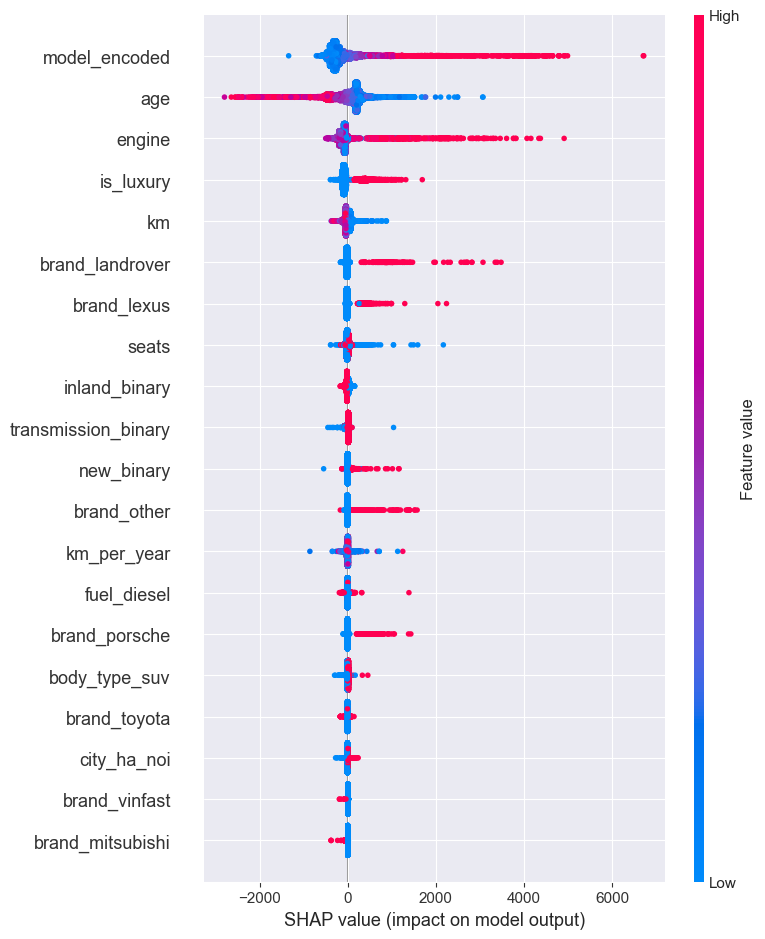

In [57]:
explainer = shap.TreeExplainer(catboost_final_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, show=True)


Phân tích SHAP cho thấy biến `model_encoded` có ảnh hưởng lớn nhất đến dự đoán giá xe. Giá trị cao của biến này làm tăng đáng kể giá dự đoán, trong khi các model phổ thông có xu hướng làm giảm giá, phản ánh đúng vai trò của model xe trong việc định vị phân khúc và giá trị thị trường.

Các đặc trưng như `age`, `engine` và `is_luxury` thể hiện mối quan hệ đơn điệu và phù hợp với thực tế: xe càng cũ hoặc chạy nhiều thì giá càng giảm, trong khi xe có động cơ lớn và thuộc phân khúc cao cấp có xu hướng tăng giá.

Nhóm các đặc trưng liên quan đến mức độ sử dụng (`km`, `km_per_year`) và thương hiệu đóng vai trò điều chỉnh, giúp mô hình phân biệt các xe có cùng model nhưng khác nhau về tình trạng sử dụng và xuất xứ.
Không quan sát thấy đặc trưng nào có tác động ngược logic hoặc gây nhiễu, cho thấy mô hình học được các mối quan hệ hợp lý và đáng tin cậy.

**SHAP Dependence Plot**

Để phân tích chi tiết hơn mối quan hệ giữa các đặc trưng quan trọng và giá dự đoán, biểu đồ SHAP dependence được sử dụng.
Biểu đồ này cho phép quan sát chiều hướng và mức độ tác động của một đặc trưng cụ thể lên dự đoán của mô hình trong toàn bộ tập dữ liệu.


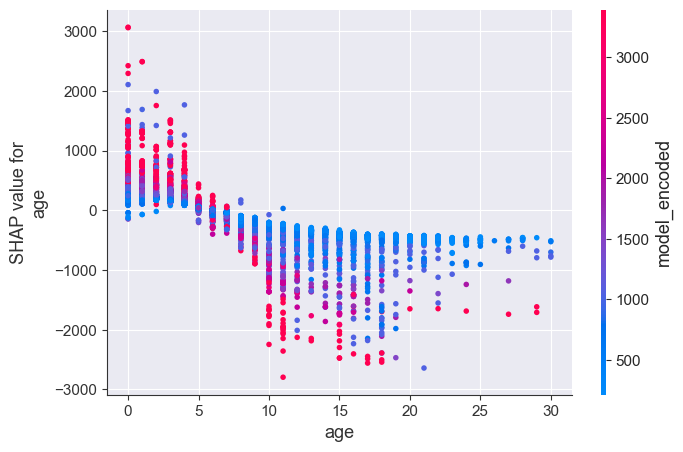

In [58]:
shap.dependence_plot(
    "age",
    shap_values,
    X_train,
    show=True
)

**SHAP Dependence Plot cho biến `age`**

Biểu đồ SHAP dependence cho thấy mối quan hệ đơn điệu và phi tuyến giữa `age` và giá dự đoán. Khi tuổi xe tăng, đóng góp của biến `age` vào giá dự đoán giảm dần, phản ánh hiện tượng khấu hao theo thời gian. Mức giảm mạnh nhất xảy ra trong giai đoạn đầu, sau đó xu hướng giảm chậm lại khi xe đã cũ.

Ngoài ra, biểu đồ cho thấy sự tương tác giữa `age` và `model_encoded`: các model cao cấp có xu hướng giữ giá tốt hơn ở cùng một mức tuổi xe so với các model phổ thông. Kết quả này phù hợp với hiểu biết thực tế về thị trường xe và củng cố tính hợp lý của mô hình.

#### 5.4 Đánh giá ưu và nhược điểm của mô hình

**Ưu điểm**

- CatBoost đạt hiệu năng dự đoán tốt nhất trong số các mô hình được thử nghiệm, với RMSE và MAE thấp hơn và R² cao hơn trên tập kiểm tra.
- Mô hình cho thấy khả năng tổng quát hóa tốt, thể hiện qua kết quả cross-validation ổn định và không xuất hiện dấu hiệu overfitting.
- Phân tích residual và phân phối lỗi cho thấy sai số phân bố đối xứng quanh 0, không có sai lệch hệ thống rõ rệt.
- Phân tích Feature Importance và SHAP cho thấy mô hình học được các mối quan hệ hợp lý và phù hợp với hiểu biết nghiệp vụ về thị trường xe.

**Nhược điểm**

- Mô hình vẫn gặp khó khăn trong việc dự đoán chính xác các xe có giá rất cao do phân phối long-tail của biến mục tiêu và số lượng mẫu hạn chế ở vùng này.
- Việc sử dụng biến `model_encoded` làm đặc trưng mạnh có thể làm giảm khả năng tổng quát hóa khi áp dụng cho các model xe hoàn toàn mới chưa xuất hiện trong tập huấn luyện.
- CatBoost có chi phí tính toán cao hơn so với các mô hình tuyến tính và một số mô hình cây đơn giản, đặc biệt khi số lượng đặc trưng và kích thước dữ liệu tăng lên.


#### 5.5 Kết luận và định hướng cải tiến

Trong nghiên cứu này, quy trình Modeling đã được xây dựng và triển khai một cách có hệ thống, từ giai đoạn benchmark các mô hình cơ bản đến tối ưu hóa siêu tham số, đánh giá mô hình và giải thích kết quả.
Kết quả cho thấy các mô hình cây tăng cường (boosting), đặc biệt là CatBoost, phù hợp với bài toán dự đoán giá xe có mối quan hệ phi tuyến và phân phối lệch phải.

Mô hình CatBoost được lựa chọn là mô hình cuối cùng nhờ đạt hiệu năng dự đoán tốt nhất, khả năng tổng quát hóa ổn định và các kết quả giải thích phù hợp với hiểu biết thực tế về thị trường xe.
Các phân tích residual và SHAP cho thấy mô hình không xuất hiện sai lệch hệ thống và học được các mối quan hệ có ý nghĩa nghiệp vụ.

Trong tương lai, mô hình có thể được cải thiện thông qua việc mở rộng dữ liệu ở các phân khúc giá cao để giảm ảnh hưởng của long-tail, bổ sung các đặc trưng chi tiết hơn về tình trạng xe và lịch sử sử dụng, hoặc thử nghiệm các biến đổi mục tiêu và hàm loss khác nhằm cải thiện độ chính xác ở các trường hợp ngoại biên.


**Learning Curve**

Để đánh giá tác động của kích thước dữ liệu huấn luyện đến hiệu năng mô hình, learning curve được sử dụng nhằm quan sát sự thay đổi sai số huấn luyện và sai số validation khi số lượng dữ liệu tăng lên.
Phân tích này giúp xác định liệu mô hình đã khai thác hết tiềm năng của dữ liệu hiện tại hay vẫn còn dư địa cải thiện khi bổ sung thêm dữ liệu.


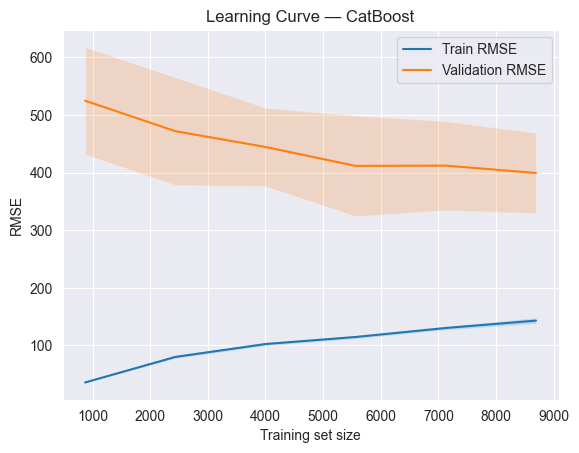

In [61]:
train_sizes, train_scores, val_scores = learning_curve(
    catboost_final_model,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
)

# Chuyển về RMSE dương
train_rmse = -train_scores
val_rmse = -val_scores

train_mean = train_rmse.mean(axis=1)
train_std = train_rmse.std(axis=1)
val_mean = val_rmse.mean(axis=1)
val_std = val_rmse.std(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label="Train RMSE")
plt.plot(train_sizes, val_mean, label="Validation RMSE")

plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.2
)
plt.fill_between(
    train_sizes,
    val_mean - val_std,
    val_mean + val_std,
    alpha=0.2
)

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.title("Learning Curve — CatBoost")
plt.legend()
plt.show()


**Nhận xét Learning Curve**

Biểu đồ learning curve cho thấy sai số validation (RMSE) giảm dần khi kích thước tập huấn luyện tăng lên và có xu hướng hội tụ, trong khi khoảng cách giữa sai số huấn luyện và sai số validation không mở rộng. Điều này cho thấy mô hình CatBoost không bị overfitting và có khả năng tổng quát hóa tốt.

Ngoài ra, việc sai số validation tiếp tục giảm khi bổ sung thêm dữ liệu gợi ý rằng mô hình vẫn còn dư địa cải thiện nếu tập dữ liệu được mở rộng, đặc biệt đối với các phân khúc giá cao vốn có số lượng mẫu hạn chế.
